In [1]:
import torch
from torchvision import models
from PIL import Image
from torchvision import transforms
from PIL import Image
import requests
import matplotlib.pyplot as plt
import cv2
import numpy as np

/opt/homebrew/anaconda3/envs/hackerdays_pool/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/anaconda3/envs/hackerdays_pool/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /opt/homebrew/anaconda3/envs/hackerdays_pool/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /opt/homebrew/anaconda3/envs/hackerdays_pool/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Select MPS device
device = torch.device("mps")
print(device)

mps


## MODEL LOADING

In [3]:
# Load a pretrained DeepLabV3 model
# model = models.segmentation.deeplabv3_resnet50(weights="DEFAULT")

# Load Mask R-CNN model pretrained on COCO dataset
model = models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT").to(device)

model.to(device).eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## TEST SEGMENTATION ON TEST IMAGE

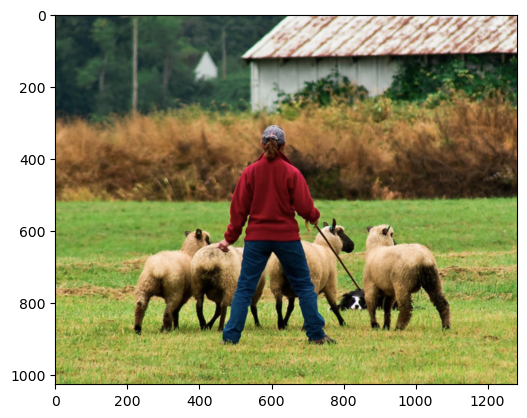

In [4]:
# Load an image and preprocess it
url = "https://raw.githubusercontent.com/pytorch/hub/master/images/deeplab1.png"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

plt.figure()
plt.imshow(image)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((520, 520)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = transform(image).unsqueeze(0).to(device)  # Move to MPS

/opt/homebrew/anaconda3/envs/hackerdays_pool/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
# Run inference
#with torch.no_grad():
    # output = model(input_tensor)["out"]

with torch.no_grad():
    predictions = model(input_tensor)

# Get masks, boxes, and labels
masks = predictions[0]["masks"].cpu().numpy()  # Segmentation masks
boxes = predictions[0]["boxes"].cpu().numpy()  # Bounding boxes
labels = predictions[0]["labels"].cpu().numpy()  # Class labels
scores = predictions[0]["scores"].cpu().numpy()  # Confidence scores

print("Number of instances found:", len(masks))


# Convert output to segmentation mask
output_predictions = output.argmax(1).byte().cpu()

# Convert to image and visualize
segmentation_map = output_predictions[0].numpy()

# Plot the original image and segmentation map side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

# Segmentation mask
ax[1].imshow(segmentation_map, cmap="jet", alpha=0.7)  # Use 'jet' colormap
ax[1].set_title("Segmentation Map")
ax[1].axis("off")

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)
ax.imshow(segmentation_map, cmap="jet", alpha=0.5)  # Overlay segmentation
ax.set_title("Overlayed Segmentation Map")
ax.axis("off")
plt.show()

RuntimeError: Couldn't load custom C++ ops. This can happen if your PyTorch and torchvision versions are incompatible, or if you had errors while compiling torchvision from source. For further information on the compatible versions, check https://github.com/pytorch/vision#installation for the compatibility matrix. Please check your PyTorch version with torch.__version__ and your torchvision version with torchvision.__version__ and verify if they are compatible, and if not please reinstall torchvision so that it matches your PyTorch install.

## LOAD VIDEO AND PREPROCESS

In [ ]:
video_path = "videos/VID20250319095759.mp4"
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"fps: {fps}, width: {frame_width}, height: {frame_height}")

fps: 30, width: 1920, height: 1080


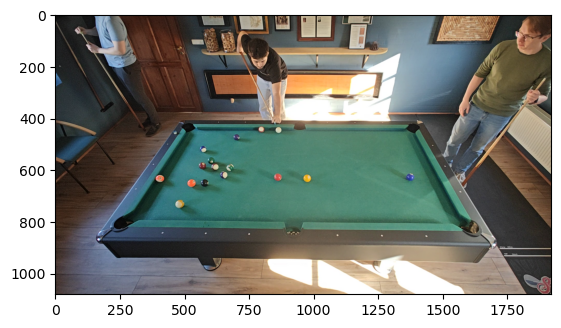

In [ ]:
# Frame number to extract
frame_number = 1000

# Set the video position to the desired frame
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

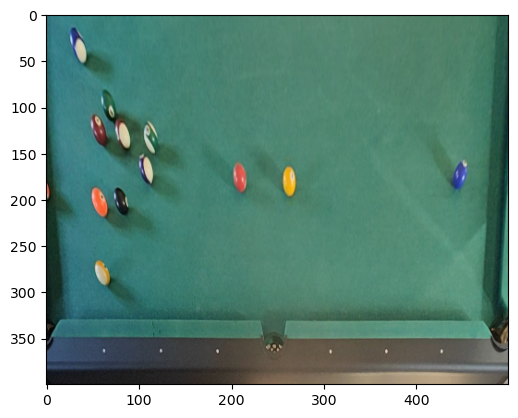

In [ ]:
# Original table corner points in the image (change based on your video)
src_points = np.array([
    [530, 500],  # Top-left corner
    [1400, 500],  # Top-right corner
    [200, 900],  # Bottom-left corner
    [1690, 920]   # Bottom-right corner
], dtype=np.float32)

# Destination points for a "flattened" top-down view
dst_points = np.array([
    [0, 0],       # New top-left
    [500, 0],     # New top-right
    [0, 400],     # New bottom-left
    [500, 400]    # New bottom-right
], dtype=np.float32)

# Compute homography matrix
H, _ = cv2.findHomography(src_points, dst_points)

warped_frame = cv2.warpPerspective(frame, H, (500, 400))
plt.imshow(warped_frame)

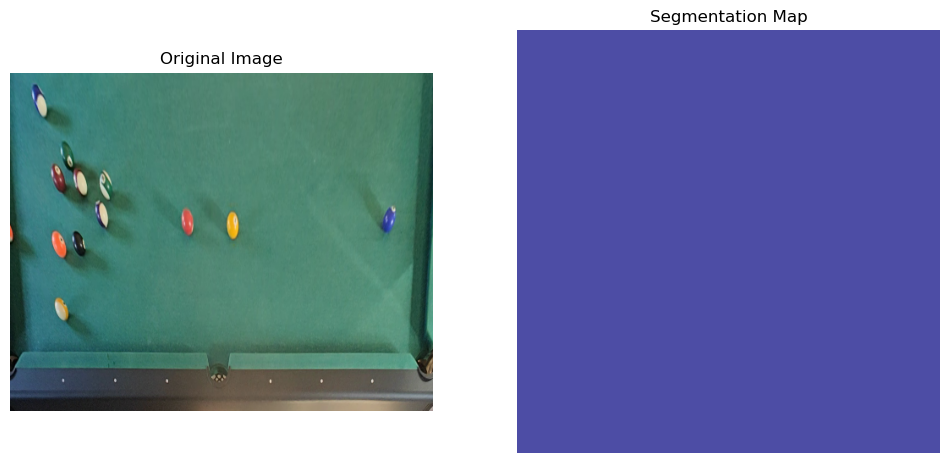

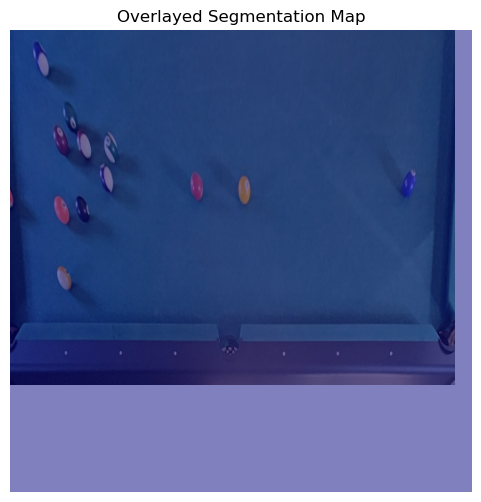

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((520, 520)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = transform(warped_frame).unsqueeze(0).to(device)  # Move to MPS

# Run inference
with torch.no_grad():
    output = model(input_tensor)["out"]

# Convert output to segmentation mask
output_predictions = output.argmax(1).byte().cpu()

# Convert to image and visualize
# segmentation_map = transforms.ToPILImage()(out
# put_predictions[0])
# segmentation_map.show()

segmentation_map = output_predictions[0].numpy()

# Plot the original image and segmentation map side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(warped_frame)
ax[0].set_title("Original Image")
ax[0].axis("off")

# Segmentation mask
ax[1].imshow(segmentation_map, cmap="jet", alpha=0.7)  # Use 'jet' colormap
ax[1].set_title("Segmentation Map")
ax[1].axis("off")

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(warped_frame)
ax.imshow(segmentation_map, cmap="jet", alpha=0.5)  # Overlay segmentation
ax.set_title("Overlayed Segmentation Map")
ax.axis("off")
plt.show()